You should be able to export most PyTorch/fast.ai models to ONNX. For this example, we'll train a pet breed classifier on the Oxford-IIIT Pet dataset. You can use any model you want (or even just use `load_learner` to load an already trained model from a .pkl file).

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PETS)

In [3]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.*)_\d+'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

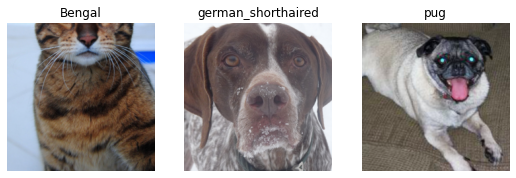

In [4]:
dls = pets.dataloaders(path/'images')
dls.show_batch(max_n=3)

In [5]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Thinking about the model's inputs and outputs

When you export a model to ONNX and load it in another ML framework, you need to be aware of which data a model requires, and which data it outputs. In other words, you need to know which inputs to feed it and how to interpret its outputs. You can inspect `learn.model` to look at the first and last layer:

In [6]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

This model starts with a `Conv2d` layer, which accepts any image size as long as it has 3 (color) channels.

And the model ends with a `Linear` layer, which outputs one activation per image class. Since there are 37 breeds in this dataset, there are 37 output activations. In particular, note that *there is no Softmax layer at the end*.

### How your application has to use this model

Based on this information, your application must:
* Feed a 3-color-channel image into the model
* Process 37 output activations, where each activation corresponds to a pet breed. The higher the activation, the more confident the model is that the image is of that activation's class.
* If your application needs to generate a probability for each class, then it has to perform the softmax operation (or something similar) itself.

Footnote: You could add a Softmax layer yourself at the end now (= after training), but for this example I'll leave it up to the application to interpret the model's outputs.

## Exporting the model to ONNX

Use [torch.onnx.export](https://pytorch.org/docs/stable/onnx.html) to export a PyTorch model to ONNX. Since fast.ai models *are* PyTorch models, this works just fine.

The method has a few parameters, but five of them are very important:
1. `model`: The model you want to export.
2. `args`: One or more tensors which represent the input of your model. This requires some explaination. The content of the tensor does not matter, but it needs to have the correct shape. In particular, the first axis must be the batch size, even if it is 1. Your application will probably ask for a prediction one image at a time, so we'll select 1 as the batch size. And we'll feed the model with 224x224 pixel images, with the aforementioned 3 color channels. Putting it all together, we'll supply a *single tensor of shape (1, 3, 224, 224)*. And your application must feed a tensor of that exact shape into the model.
3. `f`: Name of the file which should be written by the exporter. Can also be a file-like object.
4. `input_names`: Names of the model's inputs. This can be anything you like. Your application has to use these same names to access the model's input.
5. `output_names`: Names of the model's outputs. Same deal as with `input_names`.

If you trained the model on the GPU (as you probably did), you have to make sure the tensors you pass are also on the GPU (what the `.cuda()` call does), otherwise PyTorch will complain.

In [7]:
torch.onnx.export(
    learn.model,
    torch.randn(1, 3, 224, 224).cuda(),
    "pet-breed.onnx",
    input_names=["image"],
    output_names=["breeds"]
)

## Exporting the vocabulary

Since we're doing image classification here, it would certainly help to also export the *names* of the classes the model is predicting. Otherwise your application will know that class \#33 had the highest activation, but it wouldn't know what class \#33 *is*.

You can access the class names using the DataLoader's `vocab`. I'll choose the simplest possible export format here: A text file with one class per line, in the same order as the model's output activations:

In [8]:
with open("pet-breed.vocab.txt", "w") as f:
    f.write("\n".join(list(learn.dls.vocab)))

## Downloading the model

You'll now have two files next to your notebook:
* pet-breed.onnx
* pet-breed.vocab.txt

You'll need to download them both and copy them to your application.